#EXABY


# EDA Y LIMPIEZA DE DATOS


# Importación de librerías y lectura de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import re
from datetime import datetime as dt


In [2]:
# Conectamos con nuestro Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir EXABY

In [3]:
!unzip /content/drive/MyDrive/EXABY/DATA_SET.zip -d EXABY

Archive:  /content/drive/MyDrive/EXABY/DATA_SET.zip
   creating: EXABY/DATA_SET/
  inflating: EXABY/DATA_SET/Anuncios_usados.csv  
  inflating: EXABY/DATA_SET/Consumos_emisiones.csv  
  inflating: EXABY/DATA_SET/Modelos.json  
  inflating: EXABY/DATA_SET/Precio_historico.xml  
  inflating: EXABY/DATA_SET/Tablas y Variables v2.pdf  
  inflating: EXABY/DATA_SET/Tipo_de_cambio.csv  
  inflating: EXABY/DATA_SET/Ventas_nuevas.json  
  inflating: EXABY/DATA_SET/Versiones.csv  


In [4]:
df_anuncios = pd.read_csv('EXABY/DATA_SET/Anuncios_usados.csv')
df_anuncios.shape

(268252, 23)

Número de nulls

In [5]:
df_anuncios.isnull().sum()

Maker               0
 Genmodel           0
 Genmodel_ID        0
Adv_ID              0
Color           21875
Reg_year            7
Bodytype          954
Runned_Miles     1055
Engin_size       2064
Gearbox           167
Fuel_type         409
Engine_power    31810
Annual_Tax      46673
Wheelbase       27997
Height          27800
Width           28079
Length          27800
Average_mpg     41932
Top_speed       43601
Seat_num         6474
Door_num         4552
Ad_Date             0
Price_USD       16009
dtype: int64

Renombrado de columnas

In [6]:
df_anuncios.dtypes
df_anuncios.rename(columns={' Genmodel': 'Genmodel',  ' Genmodel_ID': 'Genmodel_ID'}, inplace=True)

Eliminamos ciertas columnas que no aportan valor o que podemos obtener de otras tablas:

In [7]:
df_anuncios_clean = df_anuncios.drop(columns = ['Maker', 'Color', 'Genmodel'])


Limpiamos los datos duplicados y las filas que tienen columnas que no pueden no tener datos y no se pueden sustituir:

In [8]:
df_anuncios_clean = df_anuncios_clean.drop_duplicates()
df_anuncios_clean = df_anuncios_clean[df_anuncios_clean['Reg_year'].notna()]
df_anuncios_clean = df_anuncios_clean[df_anuncios_clean['Runned_Miles'].notna()]

Antes de proceder con la limpieza, procedemos a ordenar el dataset por identificador de modelo, año de creación y millas recorridas

In [9]:
df_anuncios_clean=df_anuncios_clean.sort_values(['Genmodel_ID', 'Reg_year','Runned_Miles'], ascending=[True, True, True])

Limpiamos las columnas que puedan tener caracteres no deseados y rellenamos los valores partidos con el método ffill:


In [10]:
df_anuncios_clean['Engin_size'] = df_anuncios_clean['Engin_size'].str[:-1]
df_anuncios_clean['Engin_size'] = pd.to_numeric(df_anuncios_clean['Engin_size'])
df_anuncios_clean['Engin_size'].fillna(method='ffill', inplace=True)

In [11]:
fill_columns = ['Gearbox', 'Fuel_type', 'Seat_num', 'Door_num', 'Bodytype']
for c in fill_columns:
  df_anuncios_clean[df_anuncios_clean[c]==""] = np.NaN
  df_anuncios_clean[c].fillna(method='ffill', inplace=True)


Procedemos a rellenar los valores nulos por las medias obtenidas en base a las agrupaciones más adecuadas

In [12]:
arr_cols = ['Engine_power','Wheelbase','Height','Width','Length'] 

for c in arr_cols:
    df_anuncios_clean[c] = pd.to_numeric(df_anuncios_clean[c])
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Fuel_type', 'Reg_year','Engin_size'])[c].transform('mean'))
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Fuel_type', 'Engin_size'] )[c].transform('mean'))
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Fuel_type'])[c].transform('mean'))
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby('Genmodel_ID')[c].transform('mean'))
    df_anuncios_clean[c].fillna(df_anuncios_clean[c].mean(), inplace=True)


Salvamos los datos con caracteres raros, eliminamos los NA y los sustituimos por las medias de las agrupaciones más adecuadas

In [13]:
conflict_cols = ['Average_mpg','Top_speed']

for c in conflict_cols:
    df_anuncios_clean[c] = df_anuncios_clean[c].str.extract('(\d+)', expand=False)
    df_anuncios_clean[c] = pd.to_numeric(df_anuncios_clean[c])
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Fuel_type', 'Reg_year','Engin_size'])[c].transform('mean'))
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Fuel_type', 'Engin_size'] )[c].transform('mean'))
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Engin_size'])[c].transform('mean'))
    df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby('Genmodel_ID')[c].transform('mean'))
    df_anuncios_clean[c].fillna(df_anuncios_clean[c].mean(), inplace=True)


In [14]:
c = 'Price_USD'
df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Fuel_type', 'Reg_year','Engin_size'])[c].transform('mean'))
df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Reg_year', 'Engin_size'])[c].transform('mean'))
df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby(['Genmodel_ID', 'Reg_year'])[c].transform('mean'))
df_anuncios_clean[c] = df_anuncios_clean[c].fillna(df_anuncios_clean.groupby('Genmodel_ID')[c].transform('mean'))

df_anuncios_clean[c].fillna(df_anuncios_clean[c].mean(), inplace=True)


Obtenemos un dataset limpio

In [15]:
df_anuncios_clean.isna().sum()

Genmodel_ID         0
Adv_ID              0
Reg_year            0
Bodytype            0
Runned_Miles        0
Engin_size          0
Gearbox             0
Fuel_type           0
Engine_power        0
Annual_Tax      46308
Wheelbase           0
Height              0
Width               0
Length              0
Average_mpg         0
Top_speed           0
Seat_num            0
Door_num            0
Ad_Date             0
Price_USD           0
dtype: int64

Tratamos las columnas refrentes a fecha de venta y al precio:

In [16]:
df_anuncios_clean['Ad_Date'] =  df_anuncios_clean['Ad_Date'].apply(lambda x: re.sub('[^A-Za-z0-9]+','', str(x)))
df_anuncios_clean['Ad_Date'] = pd.to_datetime(df_anuncios_clean['Ad_Date'])


Procedemos el precio de la venta en GBP

In [17]:
df_tipo_cambio = pd.read_csv('/content/EXABY/DATA_SET/Tipo_de_cambio.csv')
df_tipo_cambio['date'] = pd.to_datetime(df_tipo_cambio['date'])
df_anuncios_clean['Price_USD'] = df_anuncios_clean['Price_USD'].round(3)
df_anuncios_clean = pd.merge(df_anuncios_clean, df_tipo_cambio,  how='left', left_on=['Ad_Date'], right_on=['date'])
df_anuncios_clean.rename(columns = {' value':'value'}, inplace=True)


Eliminamos las columnas que ya no nos hagan falta

In [18]:
df_anuncios_clean.drop(columns = ['Annual_Tax', 'date'], inplace=True)

In [19]:
df_anuncios_clean.to_csv('anuncios_final.csv')

In [20]:
df_anuncios_clean

,Genmodel_ID,Adv_ID,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Engine_power,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num,Ad_Date,Price_USD,value
0,10_1,10_1$$27,2000.0,Saloon,30000,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2018-03-01,41228.272,1.3773
1,10_1,10_1$$29,2000.0,Saloon,46000,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2017-11-01,28842.001,1.3245
2,10_1,10_1$$16,2000.0,Saloon,49700,4.4,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2017-12-01,38934.943,1.3477
3,10_1,10_1$$13,2000.0,Saloon,53444,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2018-04-01,30293.871,1.4038
4,10_1,10_1$$1,2000.0,Saloon,60000,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2018-04-01,29612.104,1.4038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267192,97_1,97_1$$1,2006.0,Convertible,1800,2.2,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-05-01,11717.746,1.3610
267193,97_1,97_1$$2,2006.0,Convertible,2009,2.2,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-05-01,10706.672,1.3610
267194,99_1,99_1$$2,2016.0,Convertible,1538,2.0,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-03-01,48111.122,1.3773
267195,99_1,99_1$$3,2016.0,Convertible,500,2.3,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-05-01,40168.433,1.3610


# Análisis exploratorio: tabla 'Versiones'

In [21]:
pd.set_option("max_rows", 10)
df_versiones = pd.read_csv('EXABY/DATA_SET/Versiones.csv')

## Detección de nulos
Vemos ahora cuántos de los campos son _null_ y cuántos _na_ y observamos que todas las variables tienen valor para todas las filas.

In [22]:
df_versiones.isnull().sum()

Genmodel_ID     0
Maker           0
Genmodel        0
Trim            0
Year            0
Price           0
Gas_emission    0
Fuel_type       0
Engine_size     0
dtype: int64

Obtenemos datos de las variables numéricas para asegurarnos de que los datos tienen valores coherentes.

In [23]:
df_versiones.describe()

,Year,Price,Gas_emission,Engine_size
count,335562.00000,335562.000000,335562.000000,335562.000000
mean,2010.14217,25437.295144,160.947479,1962.726104
std,5.41368,16954.935215,49.954728,711.154778
min,1998.00000,4499.000000,0.000000,0.000000
25%,2006.00000,16999.000000,126.000000,1587.000000
50%,2011.00000,22390.000000,152.000000,1968.000000
75%,2015.00000,29455.000000,186.000000,1998.000000
max,2021.00000,434000.000000,570.000000,6761.000000


## Detección de outliers

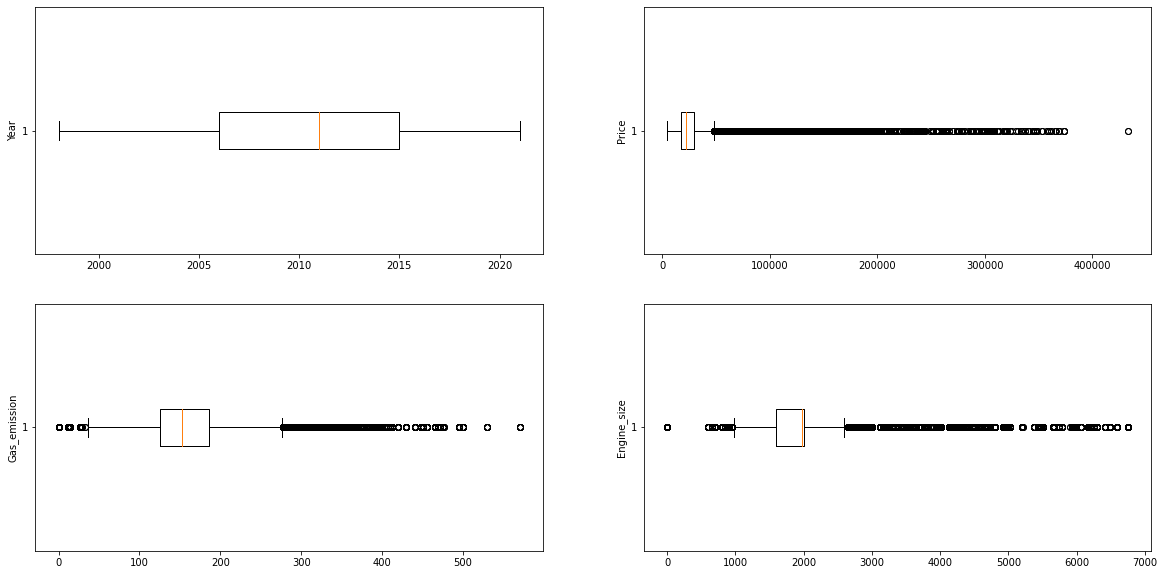

In [24]:
fig = plt.figure(figsize = (20, 10))
numeric = ['Year', 'Price', 'Gas_emission', 'Engine_size']
for i in range(len(numeric)):
    p = fig.add_subplot(2, 2, i+1)
    plt.boxplot(df_versiones[numeric[i]], vert = False)
    p.set_ylabel(numeric[i])

En esta gráfica se señalan posibles outliers mediante el método de los intercuartiles. Podemos observar que el único outlier real es el que se encuentra en precios, así que lo eliminaremos.

In [25]:
df_versiones = df_versiones[df_versiones['Price'] < 400000]

## Reducción de número de variables:
Eliminamos las columnas que nos aportan datos redundantes. Éstas son _Maker_ y _Genmodel_, que son redundantes con _Genmodel_ID_. Posteriormente agrupamos los las instancias del mismo modelo, mismo año, y mismo combustible, haciedno la media de los valores de emisiones, precio y tamaño de motor.

In [26]:
df_versiones = df_versiones.drop(columns= ['Maker', 'Genmodel'])
df_versiones_grouped = df_versiones.groupby(['Genmodel_ID', 'Fuel_type','Year', 'Engine_size']).mean()
df_versiones_grouped.reset_index(inplace = True)
df_versiones_grouped['Engine_size'] = round(df_versiones_grouped['Engine_size']/1000,1)
df_versiones_grouped

,Genmodel_ID,Fuel_type,Year,Engine_size,Price,Gas_emission
0,10_1,Petrol,1998,4.4,145000.000000,390.0
1,10_1,Petrol,1999,4.4,145000.000000,390.0
2,10_1,Petrol,1999,6.8,149000.000000,456.0
3,10_1,Petrol,2000,4.4,145000.000000,390.0
4,10_1,Petrol,2000,6.8,164300.000000,456.0
...,...,...,...,...,...,...
20399,96_9,Petrol,2011,1.6,17990.000000,169.0
20400,96_9,Petrol,2011,2.0,21520.312500,176.0
20401,96_9,Petrol,2011,2.5,25479.000000,207.8
20402,96_9,Petrol,2012,2.0,21130.714286,176.0


## Distribución de variables numéricas
A continuación representamos 

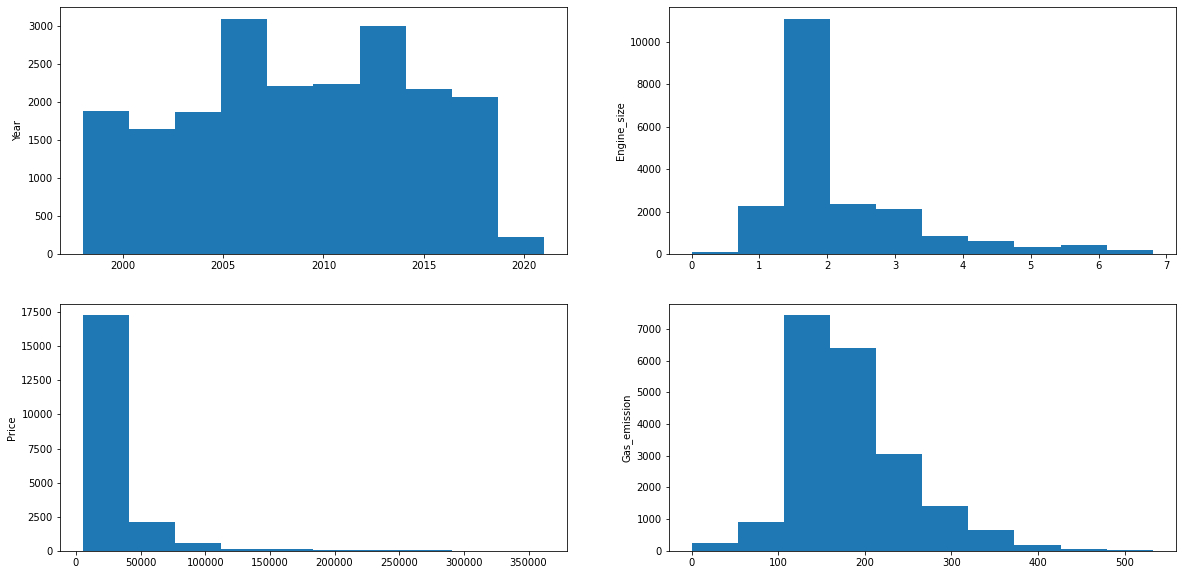

In [27]:
fig = plt.figure(figsize = (20, 10))

for i in range(2, 6):
    p = fig.add_subplot(2,2, i-1)
    df_versiones_grouped[df_versiones_grouped.columns[i]].plot.hist(ax=p)
    p.set_ylabel(df_versiones_grouped.columns[i])

## Modificación y codificación de variables categóricas

A continuación codificamos la variable categórica _Fuel_type_ mediante la codificación One Hot.



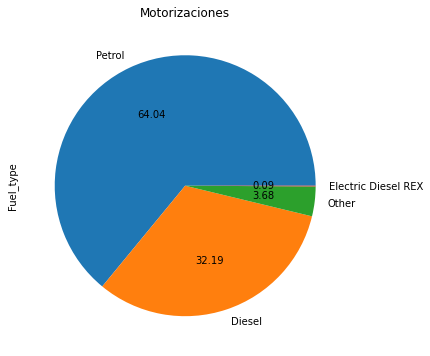

In [28]:
df_versiones_grouped['Fuel_type'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(6,6), title ='Motorizaciones')

In [29]:
df_versiones_grouped.loc[df_versiones_grouped["Fuel_type"] == "Electric Diesel REX",'Fuel_type'] = 'Other'

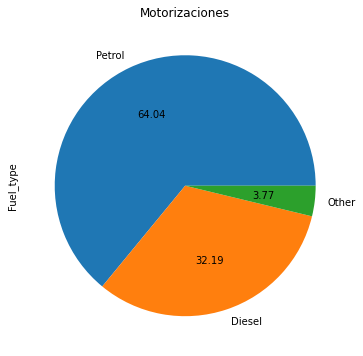

In [30]:
df_versiones_grouped['Fuel_type'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(6,6), title ='Motorizaciones')

In [31]:
'''cat_grouped = pd.get_dummies(df_versiones_grouped[['Fuel_type']])
df_versiones_grouped_onehot = pd.concat([df_versiones_grouped, cat_grouped], axis = 1).drop(columns= ['Fuel_type'])
df_versiones_grouped_onehot'''

"cat_grouped = pd.get_dummies(df_versiones_grouped[['Fuel_type']])\ndf_versiones_grouped_onehot = pd.concat([df_versiones_grouped, cat_grouped], axis = 1).drop(columns= ['Fuel_type'])\ndf_versiones_grouped_onehot"

## Procedemos a fusionar ambas tablas

In [32]:
df_versiones_grouped.columns

Index(['Genmodel_ID', 'Fuel_type', 'Year', 'Engine_size', 'Price',
       'Gas_emission'],
      dtype='object')

In [33]:
df_anuncios_clean.columns

Index(['Genmodel_ID', 'Adv_ID', 'Reg_year', 'Bodytype', 'Runned_Miles',
       'Engin_size', 'Gearbox', 'Fuel_type', 'Engine_power', 'Wheelbase',
       'Height', 'Width', 'Length', 'Average_mpg', 'Top_speed', 'Seat_num',
       'Door_num', 'Ad_Date', 'Price_USD', 'value'],
      dtype='object')

Ajustamos los nombres de las columnas:

In [34]:
df_versiones_grouped.rename(columns = {'Year':'Reg_year'}, inplace=True)

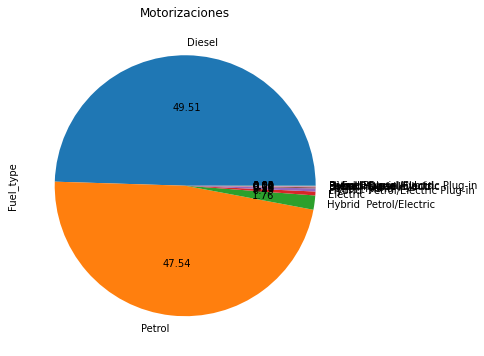

In [35]:
df_anuncios_clean['Fuel_type'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(6,6), title ='Motorizaciones')

Realizamos el mismo cambio en la variable 'Fuel_type' que para la tabla versiones

In [36]:
df_anuncios_clean['Fuel_type'].unique()

array(['Petrol', 'Diesel', 'Petrol Plug-in Hybrid', 'Petrol Ethanol',
       'Hybrid  Petrol/Electric Plug-in', 'Electric',
       'Hybrid  Diesel/Electric', 'Bi Fuel', 'Hybrid  Petrol/Electric',
       'Petrol Hybrid', 'Diesel Hybrid', 'Diesel Plug-in Hybrid',
       'Hybrid  Diesel/Electric Plug-in'], dtype=object)

In [37]:
for fuel in list(df_anuncios_clean['Fuel_type'].unique()):
  if fuel != 'Petrol' and fuel != 'Diesel':
    df_anuncios_clean.loc[df_anuncios_clean["Fuel_type"] == fuel,'Fuel_type'] = 'Other'

df_anuncios_clean


,Genmodel_ID,Adv_ID,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Engine_power,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num,Ad_Date,Price_USD,value
0,10_1,10_1$$27,2000.0,Saloon,30000,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2018-03-01,41228.272,1.3773
1,10_1,10_1$$29,2000.0,Saloon,46000,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2017-11-01,28842.001,1.3245
2,10_1,10_1$$16,2000.0,Saloon,49700,4.4,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2017-12-01,38934.943,1.3477
3,10_1,10_1$$13,2000.0,Saloon,53444,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2018-04-01,30293.871,1.4038
4,10_1,10_1$$1,2000.0,Saloon,60000,6.8,Automatic,Petrol,433.333333,3116.000000,1515.000000,2125.000000,5390.000000,13.222222,168.333333,5.0,4.0,2018-04-01,29612.104,1.4038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267192,97_1,97_1$$1,2006.0,Convertible,1800,2.2,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-05-01,11717.746,1.3610
267193,97_1,97_1$$2,2006.0,Convertible,2009,2.2,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-05-01,10706.672,1.3610
267194,99_1,99_1$$2,2016.0,Convertible,1538,2.0,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-03-01,48111.122,1.3773
267195,99_1,99_1$$3,2016.0,Convertible,500,2.3,Manual,Petrol,154.717527,2530.463211,1528.815704,1898.578145,4383.534869,50.772188,122.601132,2.0,5.0,2018-05-01,40168.433,1.3610


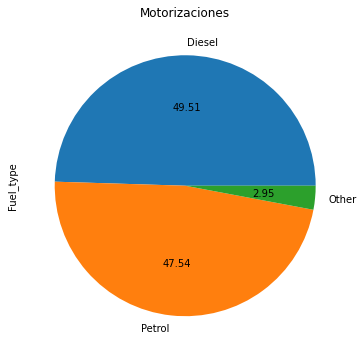

In [38]:
df_anuncios_clean['Fuel_type'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(6,6), title ='Motorizaciones')

In [39]:
full_df = pd.merge(df_anuncios_clean, df_versiones_grouped,  how='left', left_on=['Genmodel_ID', 'Reg_year', 'Fuel_type','Engin_size'], right_on=['Genmodel_ID', 'Reg_year', 'Fuel_type', 'Engine_size'])


In [40]:
full_df.dropna(inplace=True)
full_df.shape

(227960, 23)

In [41]:
full_df.drop(columns = ['Engin_size'], inplace = True)
full_df

,Genmodel_ID,Adv_ID,Reg_year,Bodytype,Runned_Miles,Gearbox,Fuel_type,Engine_power,Wheelbase,Height,...,Average_mpg,Top_speed,Seat_num,Door_num,Ad_Date,Price_USD,value,Engine_size,Price,Gas_emission
0,10_1,10_1$$27,2000.0,Saloon,30000,Automatic,Petrol,433.333333,3116.0,1515.0,...,13.222222,168.333333,5.0,4.0,2018-03-01,41228.272,1.3773,6.8,164300.0,456.0
1,10_1,10_1$$29,2000.0,Saloon,46000,Automatic,Petrol,433.333333,3116.0,1515.0,...,13.222222,168.333333,5.0,4.0,2017-11-01,28842.001,1.3245,6.8,164300.0,456.0
2,10_1,10_1$$16,2000.0,Saloon,49700,Automatic,Petrol,433.333333,3116.0,1515.0,...,13.222222,168.333333,5.0,4.0,2017-12-01,38934.943,1.3477,4.4,145000.0,390.0
3,10_1,10_1$$13,2000.0,Saloon,53444,Automatic,Petrol,433.333333,3116.0,1515.0,...,13.222222,168.333333,5.0,4.0,2018-04-01,30293.871,1.4038,6.8,164300.0,456.0
4,10_1,10_1$$1,2000.0,Saloon,60000,Automatic,Petrol,433.333333,3116.0,1515.0,...,13.222222,168.333333,5.0,4.0,2018-04-01,29612.104,1.4038,6.8,164300.0,456.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284801,96_9,96_9$$288,2012.0,Estate,91812,Manual,Diesel,113.000000,2640.0,1457.0,...,74.000000,121.000000,5.0,5.0,2018-05-01,9710.329,1.3610,1.6,23813.0,106.5
284802,96_9,96_9$$248,2012.0,Estate,94000,Manual,Diesel,113.000000,2640.0,1457.0,...,65.000000,121.000000,5.0,5.0,2018-07-01,7902.308,1.3209,1.6,23813.0,106.5
284803,96_9,96_9$$513,2012.0,Estate,95000,Manual,Diesel,113.000000,2640.0,1457.0,...,74.000000,121.000000,5.0,5.0,2018-05-01,8014.938,1.3610,1.6,23813.0,106.5
284805,96_9,96_9$$139,2012.0,Estate,96824,Manual,Diesel,113.000000,2640.0,1457.0,...,74.000000,121.000000,5.0,5.0,2018-08-01,7171.432,1.3126,1.6,23813.0,106.5


A continuación modificamos las columnas de precio para que estén en la misma moneda y añadimos las columnas relacionadas con la antigüedad y la devaluación del vehículo de cada anuncio

In [42]:
full_df['Price_USD'] = full_df['Price_USD'] / full_df['value']
full_df.rename(columns= {'Price_USD':'Ad_price_GBP', 'Price': 'Entry_price_GBP'},inplace = True)

In [43]:
full_df['Tot_devaluation'] = full_df['Ad_price_GBP'] - full_df['Entry_price_GBP']

In [44]:
full_df['Percentage_devaluation'] = full_df['Tot_devaluation'] / full_df['Entry_price_GBP']

In [45]:
print(full_df[full_df['Percentage_devaluation'] > 0].count())

Genmodel_ID               3959
Adv_ID                    3959
Reg_year                  3959
Bodytype                  3959
Runned_Miles              3959
                          ... 
Engine_size               3959
Entry_price_GBP           3959
Gas_emission              3959
Tot_devaluation           3959
Percentage_devaluation    3959
Length: 24, dtype: int64


In [46]:
full_df[full_df['Percentage_devaluation'] > 0]

,Genmodel_ID,Adv_ID,Reg_year,Bodytype,Runned_Miles,Gearbox,Fuel_type,Engine_power,Wheelbase,Height,...,Seat_num,Door_num,Ad_Date,Ad_price_GBP,value,Engine_size,Entry_price_GBP,Gas_emission,Tot_devaluation,Percentage_devaluation
58,10_3,10_3$$114,2017.0,SUV,10040,Automatic,Diesel,429.0,2995.0,1742.0,...,5.0,5.0,2018-07-01,145172.438489,1.3209,4.0,141471.666667,210.000000,3700.771822,0.026159
75,10_3,10_3$$105,2017.0,SUV,2782,Automatic,Diesel,429.0,2995.0,1742.0,...,7.0,5.0,2018-03-01,142774.285922,1.3773,4.0,141471.666667,210.000000,1302.619255,0.009208
77,10_3,10_3$$16,2017.0,SUV,3000,Automatic,Diesel,429.0,2995.0,1742.0,...,5.0,5.0,2018-08-01,153967.302301,1.3126,4.0,141471.666667,210.000000,12495.635634,0.088326
78,10_3,10_3$$88,2017.0,SUV,3000,Automatic,Diesel,429.0,2995.0,1742.0,...,5.0,5.0,2018-02-01,144203.395962,1.4264,4.0,141471.666667,210.000000,2731.729295,0.019309
90,10_3,10_3$$22,2018.0,SUV,10,Automatic,Petrol,542.0,2995.0,1742.0,...,5.0,5.0,2018-03-01,159915.196399,1.3773,4.0,139827.500000,260.000000,20087.696399,0.143661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280938,96_18,96_18$$419,2018.0,SUV,5000,Automatic,Diesel,235.0,2984.0,1776.0,...,7.0,5.0,2018-04-01,58857.854395,1.4038,2.0,53466.666667,159.333333,5391.187729,0.100833
280940,96_18,96_18$$689,2018.0,SUV,55,Automatic,Petrol,310.0,2984.0,1776.0,...,7.0,5.0,2018-08-01,60595.537864,1.3126,2.0,56146.428571,186.285714,4449.109292,0.079241
280949,96_18,96_18$$591,2018.0,SUV,6000,Automatic,Diesel,235.0,2984.0,1776.0,...,7.0,5.0,2018-08-01,54635.321499,1.3126,2.0,53466.666667,159.333333,1168.654833,0.021858
282755,96_6,96_6$$9,2018.0,Saloon,1211,Automatic,Diesel,235.0,2941.0,1443.0,...,5.0,4.0,2018-03-01,41977.739055,1.3773,2.0,40700.000000,129.363636,1277.739055,0.031394


In [ ]:
full_df['Age'] = pd.DatetimeIndex(full_df['Ad_Date']).year - full_df['Reg_year']

In [ ]:
print(full_df[full_df['Age'] < 0].count())

Genmodel_ID               53
Adv_ID                    53
Reg_year                  53
Bodytype                  53
Runned_Miles              53
                          ..
Entry_price_GBP           53
Gas_emission              53
Tot_devaluation           53
Percentage_devaluation    53
Age                       53
Length: 25, dtype: int64


In [ ]:
full_df  = full_df[full_df['Age'] > 0]

In [ ]:
full_df['Tot_Dev_PerYear'] = full_df['Tot_devaluation']/full_df['Age']
full_df['Per_Dev_PerYear'] = full_df['Percentage_devaluation']/full_df['Age']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Nos deshacemos de las variables que no vamos a utilizar (cambio de monedas)

In [ ]:
full_df.columns

Index(['Genmodel_ID', 'Adv_ID', 'Reg_year', 'Bodytype', 'Runned_Miles',
       'Gearbox', 'Fuel_type', 'Engine_power', 'Wheelbase', 'Height', 'Width',
       'Length', 'Average_mpg', 'Top_speed', 'Seat_num', 'Door_num', 'Ad_Date',
       'Ad_price_GBP', 'value', 'Engine_size', 'Entry_price_GBP',
       'Gas_emission', 'Tot_devaluation', 'Percentage_devaluation', 'Age',
       'Tot_Dev_PerYear', 'Per_Dev_PerYear'],
      dtype='object')

In [ ]:
full_df.drop(columns = ['value'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
corr = full_df.corr()
pd.options.display.max_rows = len(full_df.columns)

In [ ]:
abs(corr['Tot_devaluation']).sort_values(ascending = False)

Tot_devaluation           1.000000
Engine_size               0.657277
Gas_emission              0.562224
Entry_price_GBP           0.520321
Engine_power              0.516398
Length                    0.495253
Tot_Dev_PerYear           0.483340
Top_speed                 0.473658
Percentage_devaluation    0.396500
Average_mpg               0.357440
Reg_year                  0.286913
Age                       0.284057
Width                     0.243489
Wheelbase                 0.193754
Door_num                  0.124029
Height                    0.047503
Per_Dev_PerYear           0.044260
Ad_price_GBP              0.038681
Seat_num                  0.012276
Name: Tot_devaluation, dtype: float64

In [ ]:
abs(corr['Percentage_devaluation']).sort_values(ascending = False)

Percentage_devaluation    1.000000
Age                       0.798930
Reg_year                  0.798098
Ad_price_GBP              0.584312
Tot_devaluation           0.396500
Per_Dev_PerYear           0.303779
Entry_price_GBP           0.279945
Engine_power              0.235517
Average_mpg               0.231353
Width                     0.198690
Gas_emission              0.193291
Top_speed                 0.160676
Tot_Dev_PerYear           0.137653
Height                    0.073547
Seat_num                  0.058690
Engine_size               0.051158
Door_num                  0.039668
Length                    0.022191
Wheelbase                 0.015033
Name: Percentage_devaluation, dtype: float64

In [ ]:
abs(corr['Tot_Dev_PerYear']).sort_values(ascending = False)

Tot_Dev_PerYear           1.000000
Per_Dev_PerYear           0.648172
Tot_devaluation           0.483340
Age                       0.352773
Reg_year                  0.350613
Width                     0.308591
Length                    0.304157
Entry_price_GBP           0.289718
Engine_size               0.246552
Engine_power              0.235112
Top_speed                 0.206899
Wheelbase                 0.148907
Percentage_devaluation    0.137653
Average_mpg               0.111852
Height                    0.111121
Seat_num                  0.072317
Door_num                  0.053678
Ad_price_GBP              0.026034
Gas_emission              0.005283
Name: Tot_Dev_PerYear, dtype: float64

In [ ]:
abs(corr['Per_Dev_PerYear']).sort_values(ascending = False)

Per_Dev_PerYear           1.000000
Tot_Dev_PerYear           0.648172
Age                       0.628772
Reg_year                  0.627153
Average_mpg               0.431251
Gas_emission              0.380245
Percentage_devaluation    0.303779
Width                     0.192986
Engine_size               0.192348
Door_num                  0.166440
Engine_power              0.161224
Top_speed                 0.129554
Seat_num                  0.105778
Entry_price_GBP           0.072281
Height                    0.066708
Ad_price_GBP              0.055919
Tot_devaluation           0.044260
Wheelbase                 0.040526
Length                    0.011027
Name: Per_Dev_PerYear, dtype: float64

In [ ]:
full_df.to_csv('full_df.csv')